In [1]:
import tensorflow as tf

try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # No arguments needed for Colab
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    print("TPU initialized successfully.")
    strategy = tf.distribute.TPUStrategy(resolver)
except ValueError as e:
    print("Failed to initialize TPU. Ensure Colab runtime is set to TPU:", e)
    strategy = tf.distribute.get_strategy()  # Fallback to default strategy

TPU initialized successfully.


In [2]:
# import tensorflow as tf
# import tensorflow_datasets as tfds
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# # Load IMDB dataset
# (train_data, test_data), info = tfds.load(
#     'imdb_reviews',
#     split=[tfds.Split.TRAIN, tfds.Split.TEST],
#     as_supervised=True,
#     with_info=True
# )

# # Convert dataset to Python lists
# train_sentences, train_labels = zip(*[(sent.numpy().decode("utf8"), label.numpy()) for sent, label in train_data])
# test_sentences, test_labels = zip(*[(sent.numpy().decode("utf8"), label.numpy()) for sent, label in test_data])

# # Tokenize and sequence the data
# tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
# tokenizer.fit_on_texts(train_sentences)

# train_sequences = tokenizer.texts_to_sequences(train_sentences)
# test_sequences = tokenizer.texts_to_sequences(test_sentences)

# # Pad sequences
# max_length = 120
# train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
# test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')


In [3]:
# def serialize_example(feature, label):
#     feature = tf.train.Feature(int64_list=tf.train.Int64List(value=feature))
#     label = tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
#     features = tf.train.Features(feature={'feature': feature, 'label': label})
#     example = tf.train.Example(features=features)
#     return example.SerializeToString()

# def write_tfrecord(filename, sequences, labels):
#     with tf.io.TFRecordWriter(filename) as writer:
#         for seq, lbl in zip(sequences, labels):
#             example = serialize_example(seq, lbl)
#             writer.write(example)

# # Write TFRecord files
# write_tfrecord('train.tfrecord', train_padded, train_labels)
# write_tfrecord('test.tfrecord', test_padded, test_labels)


In [4]:
max_length=120

In [5]:
def parse_tfrecord(serialized_example):
    feature_description = {
        'feature': tf.io.FixedLenFeature([max_length], tf.int64),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    feature = example['feature']
    label = example['label']
    return feature, label

def load_dataset(file_pattern, batch_size):
    dataset = tf.data.TFRecordDataset(file_pattern)
    dataset = dataset.map(parse_tfrecord)
    dataset = dataset.shuffle(10000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset




In [6]:
# import tensorflow as tf

# try:
#     # Automatically detect and connect to TPU
#     resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="")  # Leave TPU name empty for Colab
#     tf.config.experimental_connect_to_cluster(resolver)
#     tf.tpu.experimental.initialize_tpu_system(resolver)
#     strategy = tf.distribute.TPUStrategy(resolver)
#     print("TPU initialized successfully.")
# except Exception as e:
#     print("Failed to initialize TPU. Check your Colab runtime:", e)
#     strategy = tf.distribute.get_strategy()  # Default to CPU/GPU strategy if TPU is unavailable


In [7]:
import time

In [11]:

batch_sizes=[16,32,64,128,256,512,1024]
need_time=[]
for j, i in enumerate(batch_sizes):
    # Load dataset with the current batch size
    train_dataset = load_dataset('train.tfrecord', batch_size=i)
    test_dataset = load_dataset('test.tfrecord', batch_size=i)

    # Start time for the batch size (resetting time for each batch)
    start = time.time()

    # Define and train the model
    with strategy.scope():
        model = tf.keras.Sequential([
            tf.keras.layers.Embedding(10000, 128, input_length=120),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model
        model.fit(train_dataset, validation_data=test_dataset, epochs=5)

    # End time after training
    end = time.time()
    need_time.append(end-start)

    # Print time taken for each batch size
    print(f"For batch {j + 1} (batch size = {i}), it took {end - start:.4f} seconds")


Epoch 1/5
1563/1563 [==============================] - 68s 38ms/step - loss: 0.4629 - accuracy: 0.7802 - val_loss: 0.4677 - val_accuracy: 0.7989
Epoch 2/5
1563/1563 [==============================] - 58s 37ms/step - loss: 0.2962 - accuracy: 0.8830 - val_loss: 0.4102 - val_accuracy: 0.8118
Epoch 3/5
1563/1563 [==============================] - 58s 37ms/step - loss: 0.2087 - accuracy: 0.9202 - val_loss: 0.5268 - val_accuracy: 0.8123
Epoch 4/5
1563/1563 [==============================] - 58s 37ms/step - loss: 0.1210 - accuracy: 0.9576 - val_loss: 0.7147 - val_accuracy: 0.8014
Epoch 5/5
1563/1563 [==============================] - 58s 37ms/step - loss: 0.0846 - accuracy: 0.9715 - val_loss: 0.6509 - val_accuracy: 0.7947
For batch 1 (batch size = 16), it took 304.7438 seconds
Epoch 1/5
782/782 [==============================] - 39s 41ms/step - loss: 0.4695 - accuracy: 0.7664 - val_loss: 0.3946 - val_accuracy: 0.8228
Epoch 2/5
782/782 [==============================] - 31s 39ms/step - loss: 0

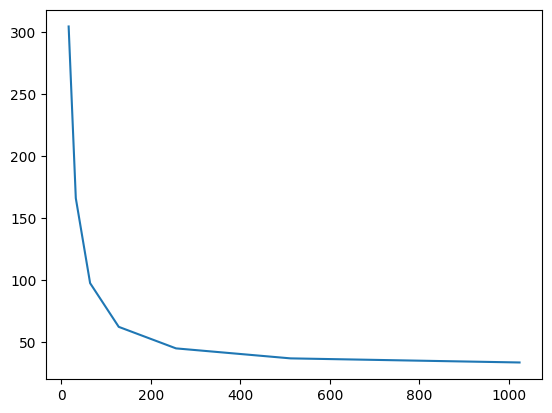

In [12]:
import matplotlib.pyplot as plt
plt.plot(batch_sizes,need_time)

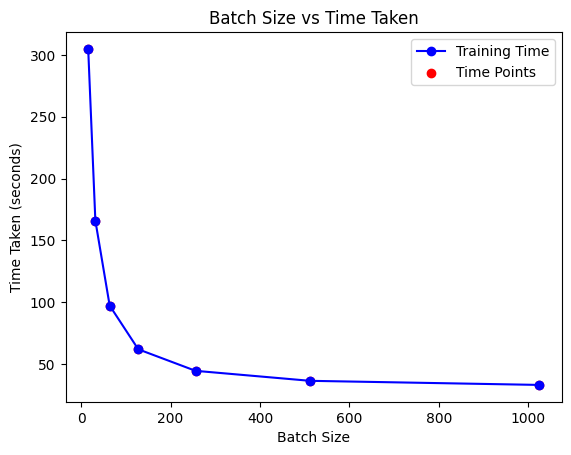

In [13]:
plt.plot(batch_sizes, need_time, label="Training Time", color='blue', marker='o')  # Line with circle markers
plt.scatter(batch_sizes, need_time, color='red', label='Time Points')  # Add scatter points for emphasis

# Adding labels and title
plt.xlabel('Batch Size')
plt.ylabel('Time Taken (seconds)')
plt.title('Batch Size vs Time Taken')
plt.legend()

# Show the plot
plt.show()

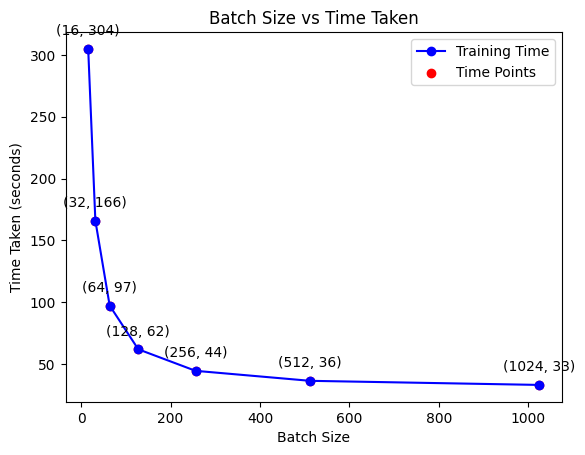

In [15]:
import matplotlib.pyplot as plt



# Plot the time vs batch size
plt.plot(batch_sizes, need_time, label="Training Time", color='blue', marker='o')  # Line with circle markers
plt.scatter(batch_sizes, need_time, color='red', label='Time Points')  # Add scatter points for emphasis

# Annotate each point with the batch size and time taken
for i, (x, y) in enumerate(zip(batch_sizes, need_time)):
    plt.annotate(f'({x}, {int(y)})', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

# Adding labels and title
plt.xlabel('Batch Size')
plt.ylabel('Time Taken (seconds)')
plt.title('Batch Size vs Time Taken')
plt.legend()

# Show the plot
plt.show()


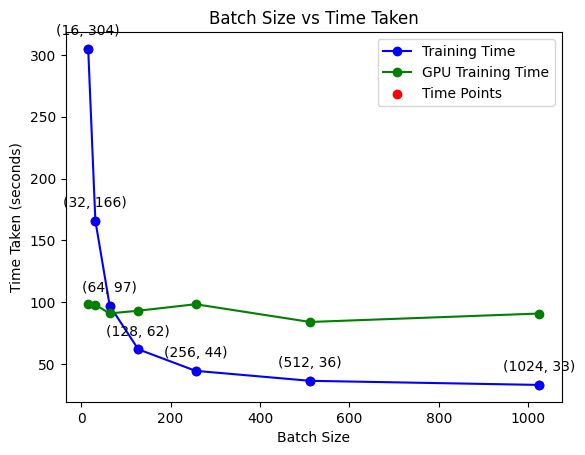

In [18]:
gpu_need_time=[98.46555972099304,
 97.95371341705322,
 91.07335829734802,
 93.23119354248047,
 98.47524571418762,
 84.14314818382263,
 90.95767998695374]
import matplotlib.pyplot as plt



# Plot the time vs batch size
plt.plot(batch_sizes, need_time, label="Training Time", color='blue', marker='o')  # Line with circle markers
plt.plot(batch_sizes, gpu_need_time, label="GPU Training Time", color='green', marker='o')  # Line with circle markers
plt.scatter(batch_sizes, need_time, color='red', label='Time Points')  # Add scatter points for emphasis
plt.sca

# Annotate each point with the batch size and time taken
for i, (x, y) in enumerate(zip(batch_sizes, need_time)):
    plt.annotate(f'({x}, {int(y)})', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')
    #plt.annotate(f'({x}, {int(gpu_need_time[i])})', (x, gpu_need_time[i]), textcoords="offset points", xytext=(0, 10), ha='center')

# Adding labels and title
plt.xlabel('Batch Size')
plt.ylabel('Time Taken (seconds)')
plt.title('Batch Size vs Time Taken')
plt.legend()

# Show the plot
plt.show()

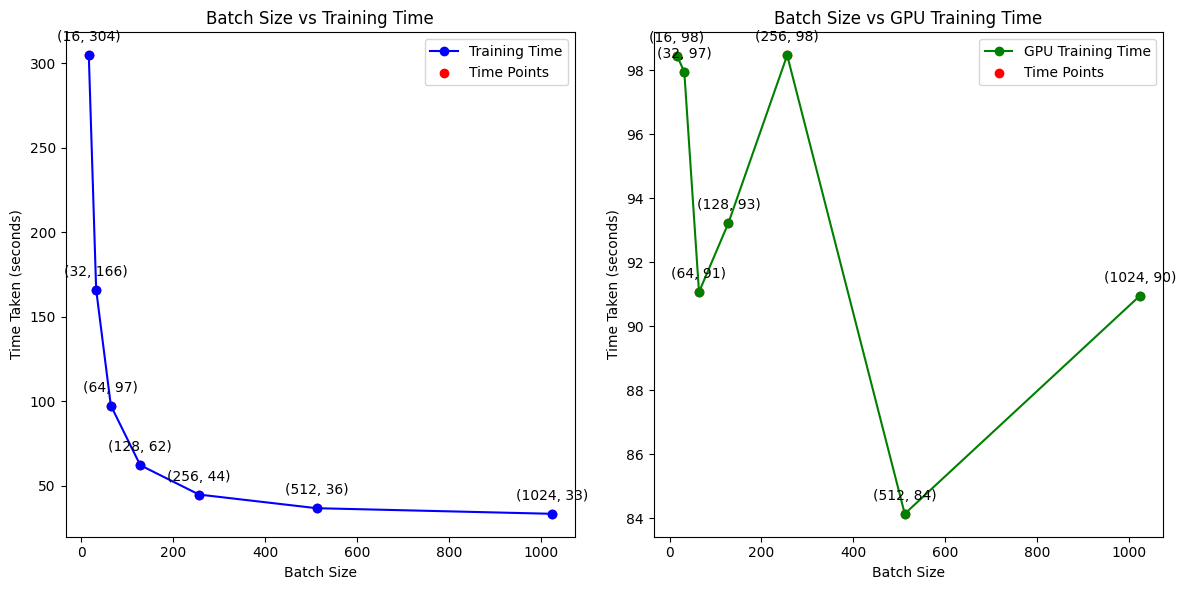

In [17]:
import matplotlib.pyplot as plt

# Example data


# Create two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot need_time on the first subplot
axes[0].plot(batch_sizes, need_time, label="Training Time", color='blue', marker='o')  # Line with circle markers
axes[0].scatter(batch_sizes, need_time, color='red', label='Time Points')  # Add scatter points for emphasis

# Annotate each point with the batch size and time taken for need_time
for i, (x, y) in enumerate(zip(batch_sizes, need_time)):
    axes[0].annotate(f'({x}, {int(y)})', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

axes[0].set_xlabel('Batch Size')
axes[0].set_ylabel('Time Taken (seconds)')
axes[0].set_title('Batch Size vs Training Time')
axes[0].legend()

# Plot gpu_need_time on the second subplot
axes[1].plot(batch_sizes, gpu_need_time, label="GPU Training Time", color='green', marker='o')  # Line with circle markers
axes[1].scatter(batch_sizes, gpu_need_time, color='red', label='Time Points')  # Add scatter points for emphasis

# Annotate each point with the batch size and time taken for gpu_need_time
for i, (x, y) in enumerate(zip(batch_sizes, gpu_need_time)):
    axes[1].annotate(f'({x}, {int(y)})', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

axes[1].set_xlabel('Batch Size')
axes[1].set_ylabel('Time Taken (seconds)')
axes[1].set_title('Batch Size vs GPU Training Time')
axes[1].legend()

# Show the plot
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


In [20]:

batch_sizes=[2048,4096]
need_time=[]
for j, i in enumerate(batch_sizes):
    # Load dataset with the current batch size
    train_dataset = load_dataset('train.tfrecord', batch_size=i)
    test_dataset = load_dataset('test.tfrecord', batch_size=i)

    # Start time for the batch size (resetting time for each batch)
    start = time.time()

    # Define and train the model
    with strategy.scope():
        model = tf.keras.Sequential([
            tf.keras.layers.Embedding(10000, 128, input_length=120),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model
        model.fit(train_dataset, validation_data=test_dataset, epochs=5)

    # End time after training
    end = time.time()
    need_time.append(end-start)

    # Print time taken for each batch size
    print(f"For batch {j + 1} (batch size = {i}), it took {end - start:.4f} seconds")


Epoch 1/5
13/13 [==============================] - 15s 453ms/step - loss: 0.6925 - accuracy: 0.5172 - val_loss: 0.6903 - val_accuracy: 0.5740
Epoch 2/5
13/13 [==============================] - 3s 244ms/step - loss: 0.6773 - accuracy: 0.6128 - val_loss: 0.5997 - val_accuracy: 0.6847
Epoch 3/5
13/13 [==============================] - 4s 286ms/step - loss: 0.5055 - accuracy: 0.7728 - val_loss: 0.4147 - val_accuracy: 0.8122
Epoch 4/5
13/13 [==============================] - 3s 248ms/step - loss: 0.3449 - accuracy: 0.8630 - val_loss: 0.3859 - val_accuracy: 0.8286
Epoch 5/5
13/13 [==============================] - 3s 245ms/step - loss: 0.2648 - accuracy: 0.9034 - val_loss: 0.5435 - val_accuracy: 0.8047
For batch 1 (batch size = 2048), it took 32.0417 seconds
Epoch 1/5
7/7 [==============================] - 20s 2s/step - loss: 0.6925 - accuracy: 0.5224 - val_loss: 0.6911 - val_accuracy: 0.5631
Epoch 2/5
7/7 [==============================] - 3s 435ms/step - loss: 0.6885 - accuracy: 0.5801 - v

In [21]:
4096/8

512.0